<h1>Get the data</h1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import talib
import warnings
from sklearn.preprocessing import MinMaxScaler

In [2]:
pd.options.display.float_format = "{:,.3f}".format
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
index_name = '000001.SS' # N225 / HSI / DJI / 000001.SS
shift_amount = -1 # -1 / -3 / -7 / -10 / -30 / -60 / -90
sideway_amount = 0.005
start_date = '2016-01-01'
end_date = '2020-11-01'
scaler = MinMaxScaler((-1,1))

INDEX1 = pdr.get_data_yahoo(index_name, start=start_date, end=end_date)
INDEX = INDEX1[['Close','High','Low','Volume','Open']]
INDEX.reset_index(inplace=True)
INDEX

,Date,Close,High,Low,Volume,Open
0,2016-01-04,"3,296.258","3,538.689","3,295.741",184400,"3,536.589"
1,2016-01-05,"3,287.711","3,328.139","3,189.605",266900,"3,196.651"
2,2016-01-06,"3,361.840","3,362.974","3,288.933",238900,"3,291.195"
3,2016-01-07,"3,125.002","3,309.657","3,115.885",70600,"3,309.657"
4,2016-01-08,"3,186.412","3,235.451","3,056.878",286400,"3,194.625"
...,...,...,...,...,...,...
1167,2020-10-26,"3,251.119","3,264.446","3,226.602",167700,"3,258.703"
1168,2020-10-27,"3,254.316","3,258.337","3,235.544",149100,"3,240.740"
1169,2020-10-28,"3,269.240","3,275.870","3,238.380",173200,"3,256.220"
1170,2020-10-29,"3,272.730","3,289.770","3,231.120",184700,"3,235.760"


<h1>Target</h1>

In [4]:
def target(df, col="Close", shift=-3, sideway=0):
    return df.assign(Target = np.where( df[col].shift(shift) > df[col] * (1 + sideway), 1,
                    np.where( df[col].shift(shift) < df[col] * (1 - sideway), -1, 0)))

In [5]:
INDEX = target(INDEX, shift=shift_amount, sideway=sideway_amount)
INDEX

,Date,Close,High,Low,Volume,Open,Target
0,2016-01-04,"3,296.258","3,538.689","3,295.741",184400,"3,536.589",0
1,2016-01-05,"3,287.711","3,328.139","3,189.605",266900,"3,196.651",1
2,2016-01-06,"3,361.840","3,362.974","3,288.933",238900,"3,291.195",-1
3,2016-01-07,"3,125.002","3,309.657","3,115.885",70600,"3,309.657",1
4,2016-01-08,"3,186.412","3,235.451","3,056.878",286400,"3,194.625",-1
...,...,...,...,...,...,...,...
1167,2020-10-26,"3,251.119","3,264.446","3,226.602",167700,"3,258.703",0
1168,2020-10-27,"3,254.316","3,258.337","3,235.544",149100,"3,240.740",0
1169,2020-10-28,"3,269.240","3,275.870","3,238.380",173200,"3,256.220",0
1170,2020-10-29,"3,272.730","3,289.770","3,231.120",184700,"3,235.760",-1


<h1>Indicator</h1>

In [6]:
def macd(idx, fast, slow, signal):
    macd, macdsignal, macdhist = talib.MACD(idx['Close'], fastperiod=fast, slowperiod=slow, signalperiod=signal)
    d = pd.DataFrame(macd)
    d = d.assign(signal=macdsignal)
    d = d.rename({0:'macd'},axis=1)
    idx = idx.assign(macd=d['macd'])
    return idx

    
def rsi(idx, time):
    RSI= talib.RSI(idx['Close'],timeperiod=time)
    RSI = RSI.to_frame()
    RSI = RSI.rename({0:'RSI'},axis=1)
    idx = idx.assign(RSI=RSI['RSI'])
    return idx

def ema(idx, time):
    real = talib.EMA(idx['Close'], timeperiod=time)
    idx = idx.assign(EMA=real)
    return idx

def stoch(idx):
    slowk, slowd = talib.STOCH(idx['High'], idx['Low'], idx['Close'])
    idx = idx.assign(STOCH_slowk=slowk)
    return idx

def obv(idx):
    real = talib.OBV(idx['Close'], idx['Volume'])
    idx = idx.assign(OBV=real)
    return idx

def ad(idx):
    real = talib.AD(idx['High'], idx['Low'], idx['Close'], idx['Volume'])
    idx = idx.assign(ADLine=real)
    return idx

def adx(idx, time):
    real = talib.ADX(idx['High'], idx['Low'], idx['Close'], timeperiod=time)
    idx = idx.assign(ADX=real)
    return idx
    
def sma(idx, time):
    real = talib.SMA(idx['Close'], timeperiod=time)
    idx = idx.assign(SMA=real)
    return idx

def cmo(idx, time):
    real = talib.CMO(idx['Close'], timeperiod=time)
    idx = idx.assign(CMO=real)
    return idx

def cci(idx, time):
    real = talib.CCI(idx['High'], idx['Low'], idx['Close'], timeperiod=time)
    idx = idx.assign(CCI=real)
    return idx

In [7]:
INDEX = macd(INDEX, 12, 26, 9) #fast=12 slow=26 signal=9
INDEX = rsi(INDEX, 14) #time=14
INDEX = ema(INDEX, 14) #time=14
INDEX = stoch(INDEX) 
INDEX = obv(INDEX) 
INDEX = ad(INDEX)
INDEX = adx(INDEX, 14) #time=14
INDEX = sma(INDEX, 14) #time=14
INDEX = cmo(INDEX, 14) #time=14
INDEX = cci(INDEX, 14) #time=14
INDEX

INDEX_re = INDEX[['Date','Target','macd','RSI','STOCH_slowk','EMA','OBV','ADLine','ADX','SMA','CMO','CCI']]
INDEX_re.set_index('Date',inplace=True)
INDEX_re = INDEX_re.bfill(axis ='rows')
INDEX_re

,Target,macd,RSI,STOCH_slowk,EMA,OBV,ADLine,ADX,SMA,CMO,CCI
Date,,,,,,,,,,,
2016-01-04,0,-62.267,32.172,16.571,"3,066.697","184,400.000","-183,615.047",64.176,"3,066.697",-35.656,-77.076
2016-01-05,1,-62.267,32.172,16.571,"3,066.697","-82,500.000","-72,492.437",64.176,"3,066.697",-35.656,-77.076
2016-01-06,-1,-62.267,32.172,16.571,"3,066.697","156,400.000","159,089.442",64.176,"3,066.697",-35.656,-77.076
2016-01-07,1,-62.267,32.172,16.571,"3,066.697","85,800.000","95,132.882",64.176,"3,066.697",-35.656,-77.076
2016-01-08,-1,-62.267,32.172,16.571,"3,066.697","372,200.000","224,233.428",64.176,"3,066.697",-35.656,-77.076
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-26,0,-2.106,41.647,19.794,"3,298.795","21,988,700.000","34,071,746.749",12.243,"3,303.531",-16.706,-102.883
2020-10-27,0,-5.476,42.269,16.981,"3,292.864","22,137,800.000","34,168,240.130",12.455,"3,305.670",-15.463,-107.479
2020-10-28,0,-6.863,45.203,30.787,"3,289.714","22,311,000.000","34,280,179.484",12.109,"3,309.327",-9.593,-99.662


<h1>Feature selection</h1>

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
result = ['macd', 'RSI', 'EMA', 'ADLine', 'CMO', 'CCI']
INDEX_re = INDEX_re[result]
target_del33 = INDEX[['Date','Target']]
target_del33.set_index('Date',inplace=True)
INDEX_re = INDEX_re.assign(Target=target_del33['Target'])
INDEX_re

,macd,RSI,EMA,ADLine,CMO,CCI,Target
Date,,,,,,,
2016-01-04,-62.267,32.172,"3,066.697","-183,615.047",-35.656,-77.076,0
2016-01-05,-62.267,32.172,"3,066.697","-72,492.437",-35.656,-77.076,1
2016-01-06,-62.267,32.172,"3,066.697","159,089.442",-35.656,-77.076,-1
2016-01-07,-62.267,32.172,"3,066.697","95,132.882",-35.656,-77.076,1
2016-01-08,-62.267,32.172,"3,066.697","224,233.428",-35.656,-77.076,-1
...,...,...,...,...,...,...,...
2020-10-26,-2.106,41.647,"3,298.795","34,071,746.749",-16.706,-102.883,0
2020-10-27,-5.476,42.269,"3,292.864","34,168,240.130",-15.463,-107.479,0
2020-10-28,-6.863,45.203,"3,289.714","34,280,179.484",-9.593,-99.662,0


<h1>Train test split</h1>

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(INDEX_re[result], INDEX_re['Target'], test_size=0.15)

<h1>Model</h1>

<h3>average = None</h3>
<ul>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.recall_score.html">recall_score</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_score.html">precision_score</a></li>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">f1_score</a></li>
</ul>
<h3>roc_auc_score</h3>
<ul>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html">roc_auc_score</a></li>
</ul>
<h3>pos_label = 1 for roc_curve</h3>
<ul>
    <li><a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html">roc_curve</a></li>
</ul>

In [10]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
random_seed = 0
# k_fold = 5

In [11]:
def print_score(y_test, y_pred):
#     print(y_pred)
    print('Accuracy Score:', metrics.accuracy_score(y_test, y_pred))
#     print('Recall Score:', metrics.recall_score(y_test, y_pred, average=None))
#     print('Precision Score:', metrics.precision_score(y_test, y_pred, average=None))
#     print('F1-Score:', metrics.f1_score(y_test, y_pred, average=None))
#     print('AUC:', metrics.roc_auc_score(y_test, y_pred, multi_class='ovr'))
#     cm = confusion_matrix(y_test, y_pred)
#     print(cm)
    
# def print_cross_val(model, X_train, y_train, k_fold):
#     score = cross_val_score(model, X_train, y_train, cv=k_fold, scoring='accuracy')
#     print('cross validation', k_fold, 'times :', score)
    
def get_roc_curve(y_test, y_pred):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred, pos_label=1)
    return fpr, tpr, _

In [12]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# RandomForestClassifier
# https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
# max_features = 0.2
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=random_seed, max_features=0.2,n_estimators=1000)

rf.fit(X_train, np.ravel(y_train,order='C'))
y_pred = rf.predict(X_test)
print_score(y_test, y_pred)
rf_fpr, rf_tpr, _ = get_roc_curve(y_test, y_pred)

# rf_probs = rf.predict_proba(X_test)
# rf_auc  = roc_auc_score(y_test, rf_probs,multi_class='ovr')
# print_cross_val(rf, X_train, y_train, k_fold)
# print("AUC score : ",rf_auc)

Accuracy Score: 0.38636363636363635


In [14]:
# DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=random_seed)

dt.fit(X_train, np.ravel(y_train,order='C'))
y_pred = dt.predict(X_test)
print_score(y_test, y_pred)
dt_fpr, dt_tpr, _ = get_roc_curve(y_test, y_pred)

# dt_probs = dt.predict_proba(X_test)
# dt_auc  = roc_auc_score(y_test, dt_probs,multi_class='ovr')
# print_cross_val(dt, X_train, y_train, k_fold)
# print("AUC score : ",dt_auc)

Accuracy Score: 0.4034090909090909


In [15]:
# LogisticRegression
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=random_seed)

lr.fit(X_train, np.ravel(y_train,order='C'))
y_pred = lr.predict(X_test)
print_score(y_test, y_pred)
lr_fpr, lr_tpr, _ = get_roc_curve(y_test, y_pred)

# lr_probs = lr.predict_proba(X_test)
# lr_auc  = roc_auc_score(y_test, lr_probs,multi_class='ovr')
# print_cross_val(lr, X_train, y_train, k_fold)
# print("AUC score : ",lr_auc)

Accuracy Score: 0.4431818181818182


In [16]:
# MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=3000, random_state=0)

mlp.fit(X_train, np.ravel(y_train,order='C'))
y_pred = mlp.predict(X_test)
print_score(y_test, y_pred)
mlp_fpr, mlp_tpr, _ = get_roc_curve(y_test, y_pred)

# mlp_probs = mlp.predict_proba(X_test)
# mlp_auc  = roc_auc_score(y_test, mlp_probs,multi_class='ovr')
# print_cross_val(mlp, X_train, y_train, k_fold)
# print("AUC score : ",mlp_auc)

Accuracy Score: 0.4431818181818182


# max_bin, [default=256]
Only used if tree_method is set to hist or gpu_hist.<br>
Maximum number of discrete bins to bucket continuous features.<br>
Increasing this number improves the optimality of splits at the cost of higher computation time.<br>
tree_method string [default= auto]<br>
hist: Faster histogram optimized approximate greedy algorithm.<br>
gpu_hist: GPU implementation of hist algorithm.

In [17]:
# XGB
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=10,tree_method='gpu_hist',max_bin=255)

xgb.fit(X_train, np.ravel(y_train,order='C'))
y_pred = xgb.predict(X_test)
print_score(y_test, y_pred)
xgb_fpr, xgb_tpr, _ = get_roc_curve(y_test, y_pred)

# xgb_probs = xgb.predict_proba(X_test)
# xgb_auc  = roc_auc_score(y_test, xgb_probs,multi_class='ovr')
# print_cross_val(xgb, X_train, y_train, k_fold)
# print("AUC score : ",xgb_auc)

c:\users\windows 10\appdata\local\programs\python\python39\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:51:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy Score: 0.4147727272727273


In [18]:
# LGBM
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier(learning_rate=0.1,tree_learner='data',max_bin=255)

lgbm.fit(X_train, np.ravel(y_train,order='C'))
y_pred = lgbm.predict(X_test)
print_score(y_test, y_pred)
lgbm_fpr, lgbm_tpr, _ = get_roc_curve(y_test, y_pred)

# lgbm_probs = lgbm.predict_proba(X_test)
# lgbm_auc  = roc_auc_score(y_test, lgbm_probs,multi_class='ovr')
# print_cross_val(lgbm, X_train, y_train, k_fold)
# print("AUC score : ",lgbm_auc)

Accuracy Score: 0.4034090909090909


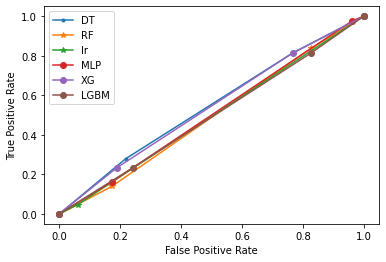

In [19]:
# plot the roc curve for the models
plt.plot(dt_fpr, dt_tpr, marker='.', label='DT')
plt.plot(rf_fpr,  rf_tpr,  marker='*', label='RF')
plt.plot(lr_fpr, lr_tpr, marker='*', label='lr')
plt.plot(mlp_fpr, mlp_tpr, marker='o', label='MLP')
plt.plot(xgb_fpr, xgb_tpr, marker='o', label='XG')
plt.plot(lgbm_fpr, lgbm_tpr, marker='o', label='LGBM')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

# show the legend
plt.legend()

# show the plot
plt.show()

<h1>Prediction</h1>

In [20]:
t_index_name = '000001.SS' # N225 / HSI / DJI / 000001.SS
t_shift_amount = -1 # -1 / -3 / -7 / -10 / -30 / -60 / -90
t_sideway_amount = 0.005
t_start_date = '2020-11-18'
t_end_date = '2021-08-19'

today = pdr.get_data_yahoo(t_index_name, start=t_start_date, end=t_end_date)
today = target(today, shift=t_shift_amount, sideway=t_sideway_amount)
today.reset_index(inplace=True);
today1 = today[['Close','Open']]
today = macd(today, 12, 26, 9) #fast=12 slow=26 signal=9
today = rsi(today, 14) #time=14
today = ema(today, 14) #time=14
today = stoch(today)
today = obv(today)
today = ad(today)
today = adx(today, 14) #time=14
today = sma(today, 14) #time=14
today = cmo(today, 14) #time=14
today = cci(today, 14) #time=14

today.set_index('Date',inplace=True)
today.dropna(inplace=True)
today_result = today["Target"];
today = today[result]
today_test = scaler.fit_transform(today);

In [21]:
def today_acc(y_pred):
    print(y_pred)
    r = []
    for i in range(len(y_pred)):
        if today_result[i] == 0:
            r.append(y_pred[i] == today_result.tolist()[i])
            
    r = np.array(r)
    n_true = (r == True).sum()
    n_false = (r == False).sum()
    print(n_true, n_false, n_true + n_false)
    print('Accuracy Score:', metrics.accuracy_score(y_pred, today_result))

def frame(y_pred):
    return pd.DataFrame(y_pred)

In [22]:
# RandomForest
y_pred = rf.predict(today_test)
print('RandomForest')
today_acc(y_pred)
result_table = frame(y_pred)
result_table = result_table.rename(columns={0:'RF'})

RandomForest
[-1 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1  0 -1  0 -1  0  1 -1  1  0  0  0  0
  1  0  0  0  0  0 -1  0  0  0  0  0  0  0  0  0 -1 -1  1  1  1  1  1  0
  1  1  1  1  1  1  1  0  1  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
  0  0  0  0  0  1  0  0  0  1  0  0  1  0  0  0  0  0  1  0  0  0  1  1
 -1 -1 -1 -1 -1  0 -1 -1  0 -1 -1 -1 -1  0  0 -1  0  0  0  1  1  0  1  0
  0  0  0  0  0 -1  0 -1  0  1  1  0  0  0  0  1  1  1  1  0  0 -1 -1 -1
 -1  0  0  0  0  0  0  1  0]
37 28 65
Accuracy Score: 0.40522875816993464


In [23]:
# DecisionTree
y_pred = dt.predict(today_test)
print('DecisionTree')
today_acc(y_pred)
result_table = result_table.assign(DT=frame(y_pred))

DecisionTree
[ 0  0  0  0  0 -1 -1  0  0 -1  1  1 -1 -1 -1 -1 -1 -1  1  1  1  1  1  1
  1  1 -1 -1  0  0  1 -1 -1 -1 -1 -1 -1 -1  1  1  1  0  1  0  1  1  1 -1
  1  1  1 -1 -1  1 -1 -1 -1  1 -1  0  0  0  0  0  0  0 -1  0  0  0  0  0
  0  1  0  1  0  1 -1  1  0  0  0  0  1  0  0  0  0  0  0  1 -1  1  1  1
  0  1 -1 -1 -1  0  0 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  1  1 -1  1  1
  0  1  1  0  1  1  0  1  1  1  1 -1  0  0  1  0  1  0  1  1  1 -1 -1  1
 -1 -1  0 -1  0  0 -1  1  0]
23 42 65
Accuracy Score: 0.37254901960784315


In [24]:
# LogisticRegression
y_pred = lr.predict(today_test)
print('LogisticRegression')
today_acc(y_pred)
result_table = result_table.assign(LR=frame(y_pred))

LogisticRegression
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0]
65 0 65
Accuracy Score: 0.43790849673202614


In [25]:
# MLP
y_pred = mlp.predict(today_test)
print('MLP')
today_acc(y_pred)
result_table = result_table.assign(MLP=frame(y_pred))

MLP
[ 0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0
  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0 -1  0  0 -1  0  0  0
  0  0  0  0 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0 -1 -1  0  0  0
  0  0  0 -1  0  0  0  0  0 -1 -1 -1  0  0  0  0  0  1  0  0  0  0  0 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  1  0  0  0  0  0
  0  0  0  0  0  0  0  0  0]
45 20 65
Accuracy Score: 0.41830065359477125


In [26]:
# XGB
y_pred = xgb.predict(today_test)
print('XGB')
today_acc(y_pred)
result_table = result_table.assign(XGB=frame(y_pred))

XGB
[ 0  0  1  0  1  0  0 -1 -1 -1 -1  1 -1 -1  0 -1  1  0  0  0  0  0  1  0
  1  0 -1  0  0  0 -1  0  0  0  0  0  1  1  0  0 -1 -1  0  0  0  0  0  0
  1  0  1  1  1  1  0  0  1  0  0  0  0  0  0  1  1  0  0  0  0  1  1  0
  0  0  0  0  0  1  0  1  1  1  1  1  1  0  0  1  1  1  1  0  0  0  1  0
  1  0  0 -1  1  1 -1 -1 -1  0  0  0 -1  0  0 -1 -1  0  0  1  1  0  1 -1
  0  0  0  0  0  1 -1 -1  0  1  1  0  0  0 -1  1  1  1  1  0  0 -1 -1  0
 -1  0  0  0  0  0  1 -1  0]
34 31 65
Accuracy Score: 0.37254901960784315


In [27]:
# LGBM
y_pred = lgbm.predict(today_test)
print('LGBM')
today_acc(y_pred)
result_table = result_table.assign(LGBM=frame(y_pred))

LGBM
[ 0  0  0  0  1  0  0 -1 -1 -1  0  0  0  0  0 -1  0  1  1  1  0  0  0  0
  1  0  0  0  0  0 -1  0  0  0  0  0  0  1  0  0  1 -1  0  0  0  0  0  0
  1  1  1  1  0  0  0  0  1  0  0  0  0  0  1  1  0  0  0  0  0 -1 -1  0
  1  0  0  0  1  1  0  0  0  1  1  0  1  0  0  0  1  1  1  0  0  0  0  0
  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0  1  0 -1 -1 -1  0  0  1  1 -1  1  1
  0  1  0  0  0 -1 -1 -1 -1  1  1  0  0  0 -1  1  1  1  1  0  0  0  0  1
 -1  0  0  0  0  0  1  0  1]
41 24 65
Accuracy Score: 0.43137254901960786


In [28]:
result_table


,RF,DT,LR,MLP,XGB,LGBM
0,-1,0,0,0,0,0
1,-1,0,0,0,0,0
2,-1,0,0,0,1,0
3,1,0,0,-1,0,0
4,1,0,0,-1,1,1
...,...,...,...,...,...,...
148,0,0,0,0,0,0
149,0,0,0,0,0,0
150,0,-1,0,0,1,1
151,1,1,0,0,-1,0


In [29]:
arr_re = []
for i in range(len(result_table)):
    up = 0
    down = 0
    sideway = 0
    for j in range(5):
        if(result_table.loc[i:i,:].values[0][j] == 1):
            up +=1
        elif(result_table.loc[i:i,:].values[0][j] == 0):
            sideway += 1
        else:
            down += 1
    if(up > down and up > sideway):
        arr_re.append(1)
    elif(down > up and down > sideway):
        arr_re.append(-1)
    else:
        arr_re.append(0)

In [30]:
arr_re_frame = pd.DataFrame(arr_re)
print('Accuracy Score:', metrics.accuracy_score(arr_re_frame, today_result))

Accuracy Score: 0.39215686274509803


In [31]:
result_table['Target'] = arr_re_frame

In [32]:
to_trade = result_table[['Target']]
to_trade = to_trade.assign(Open=today1[['Open']],Close=today1[['Close']])
to_trade

,Target,Open,Close
0,0,"3,337.332","3,347.303"
1,0,"3,339.086","3,363.088"
2,0,"3,359.600","3,377.730"
3,0,"3,384.100","3,414.490"
4,0,"3,407.409","3,402.823"
...,...,...,...
148,0,"3,601.680","3,573.180"
149,0,"3,572.620","3,591.200"
150,0,"3,600.550","3,588.780"
151,0,"3,569.890","3,518.760"


In [33]:
f = 0.001
value = 1000000
cash = value
onhand = 0
p = 0.5
d = 0
while d < len(to_trade):
    if to_trade.loc[d:d,:].values[0][0] == 1:
        n = int(p*cash//to_trade.shift(-1).values[0][1])
        amount = n * to_trade.shift(-1).values[0][1]
        cash = cash - amount * (1+f)
        onhand = onhand + n
        
    if to_trade.loc[d:d,:].values[0][0] == -1:
        n = int(onhand*p)
        amount = n * to_trade.shift(-1).values[0][1]
        cash = cash + amount * (1-f)
        onhand = onhand - n
       
#         print(onhand) 
    value = cash + onhand * to_trade.loc[d:d,:].values[0][2]
    
    d +=1

print(value)

1002864.3837539067
